# Assignment 1
In this problem, we are given n stocks to chose everyday during the m-day period and want to maximize the total return. Here I first assume the stock return is stationary and I use epsilon-greedy bandit method:

In [169]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display
import math
import pandas as pd
from numpy.linalg import inv
import statsmodels.api as sm

I generate stock return data using Cauchy distribution with degree = $3$, standard deviation = 0.1, mean generated uniformly from $-1$ to $1$.

In [17]:
def stock_return_generate(m, n, standard_deviation = 0.1):
    stock_returns = []
    stock_mean_returns = list(np.random.uniform(-1, 1, n))
    for i in range(n):
        stock_return = np.random.standard_t(3, size = m)
        stock_return = np.array(stock_return)*standard_deviation + stock_mean_returns[i]
        stock_returns.append(stock_return)
    stock_returns = np.array(stock_returns)
    return stock_returns, stock_mean_returns

In [18]:
def get_optimal_price(stock_mean_returns):
    return stock_mean_returns.index(max(stock_mean_returns))

In [84]:
def plot_graph(epsilons, steps, average_returns, regret_values, algorithm, optimal_initial_value = True):
    df1 = pd.DataFrame()
    for j in range(len(epsilons)):
        if algorithm == 'Epsilon-greedy Method':
            df1[f'epsilon = {epsilons[j]}'] = average_returns[j]
        else:
            df1[f'degree of exploration = {epsilons[j]}'] = average_returns[j]
    df1['steps'] = steps
    df1.set_index('steps', inplace = True)
    title = ''
    if algorithm == 'Epsilon-greedy Method' and optimal_initial_value:
        title = f'Average Return for {algorithm} vs steps - Initial value optimal'
    else:
        title = f'Average Return for {algorithm} Method vs steps'
    df1.plot(title = title, xlabel = 'steps', ylabel = 'average return', legend = True)
    plt.show()
    
    df2 = pd.DataFrame()
    for j in range(len(epsilons)):
        if algorithm == 'Epsilon-greedy Method':
            df2[f'epsilon = {epsilons[j]}'] = regret_values[j]
        else:
            df2[f'degree of exploration = {epsilons[j]}'] = regret_values[j]
    df2['steps'] = steps
    df2.set_index('steps', inplace = True)
    title = ''
    if algorithm == 'Epsilon-greedy Method' and optimal_initial_value:
        title = f'Regret Value for {algorithm} vs steps - Initial value optimal'
    else:
        title = f'Regret Value for {algorithm} vs steps'
    df2.plot(title = title, xlabel = 'steps', ylabel = 'regret value', legend = True)
    plt.show()

## Epsilon Greedy Algorithm for Constant and Non-constant Mean
In the epsilon greedy algorithm, the agent have probability $\epsilon$ to choose a stock randomly from the basket or pick the stock with the maximum estimated average return with probability $1-\epsilon$. The estimated average return is equal to the average of all the real returns we got for each stock. 

The updating step for the estimated average return is the following:
$$
\begin{align}
Q_{t}(a) = Q_{t-1}(a) + (R_{t}(a) - Q_{t-1}(a))/N_{t}(a)
\end{align}
$$
where $Q_{t}(a)$ is the estimated average return for stock a at round t, $R_{t}(a)$ is the real return we get after we pick the stock a.

I also implement the constant step size $\epsilon$-greedy method where $\frac{1}{N_{t}(a)}$ is replaced by $\frac{1}{c}$ where c is a fixed number.

In [85]:
class epsilon_greedy_agent():
    def __init__(self, epsilon, m, n, constant_step = -1, optimal_initial_value = True):
        self.stock_number = n
        self.round_number = m
        self.epsilon = epsilon
        if optimal_initial_value == False:
            self.estimated_price_return = [0]*n
        else:
            self.estimated_price_return = [5]*n
        self.stock_chosen_time = [0]*n
        self.regret_value = 0
        self.average_return = 0
        self.average_return_history = []
        self.regret_value_history = []
        self.cummulative_return = []
        self.mode = 'stationary_mean'
        if constant_step > -1:
            self.mode = 'non_stationary_mean'
        self.constant_step = constant_step
        
        
    def pick_stock(self):
        number1 = random.uniform(0, 1)
        if number1 <= self.epsilon:
            chosen_stock = random.randrange(self.stock_number)
        else:
            chosen_stock = self.estimated_price_return.index(max(self.estimated_price_return))
        return chosen_stock
    
    def update(self, stock_values, chosen_stock, optimal_stock, i):
        self.stock_chosen_time[chosen_stock] += 1
        if self.mode == 'stationary_mean':
            self.estimated_price_return[chosen_stock] += (stock_values[chosen_stock] - \
                                            self.estimated_price_return[chosen_stock])/self.stock_chosen_time[chosen_stock]
        if self.mode == 'non_stationary_mean':
            self.estimated_price_return[chosen_stock] += (stock_values[chosen_stock] - \
                                                          self.estimated_price_return[chosen_stock])/self.constant_step
        self.regret_value += stock_values[optimal_stock] - stock_values[chosen_stock]
        self.average_return += (stock_values[chosen_stock] - self.average_return)/i
        self.average_return_history.append(self.average_return)
        self.regret_value_history.append(self.regret_value)
        self.cummulative_return.append(self.average_return*i)

In [86]:
def epsilon_greedy(m, epsilon, n, standard_deviation, stock_returns, stock_mean_returns, \
                   optimal_stock, constant_step = -1, optimal_initial_value = True):
    investor_1 = epsilon_greedy_agent(epsilon, m, n, constant_step = -1, optimal_initial_value = optimal_initial_value)
    for i in range(m):
        chosen_stock = investor_1.pick_stock()
        stock_values = stock_returns[:, i]
        investor_1.update(stock_values, chosen_stock, optimal_stock, i + 1)
    return investor_1.average_return_history, investor_1.regret_value_history, investor_1.cummulative_return

In [87]:
def visualization(m, n, optimal_initial_value, test = 1000):
    steps = list(range(m))
    average_returns = []
    regret_values = []
    standard_deviation = 0.1
    upper_bound_epsilon = pow(m, -1/3)*pow(n*math.log(m), 1/3)
    epsilons = [ 0, 0.05, 0.1, upper_bound_epsilon]
    stock_returns, stock_mean_returns = stock_return_generate(m, n, standard_deviation)
    optimal_stock = get_optimal_price(stock_mean_returns)
    for j in range(len(epsilons)):
        average_return_ = []
        regret_value_ = []
        for k in range(test):
            if optimal_initial_value:
                _average_return_, _regret_value_ = epsilon_greedy(m, epsilons[j], n, standard_deviation, stock_returns,\
                                                            stock_mean_returns, optimal_stock)[:2]
            else:
                _average_return_, _regret_value_ = epsilon_greedy(m, epsilons[j], n, standard_deviation, stock_returns,\
                                                            stock_mean_returns, optimal_stock, optimal_initial_value = False)[:2]
            average_return_.append(_average_return_)
            regret_value_.append(_regret_value_)
        average_return_ = np.array(average_return_)
        regret_value_ = np.array(regret_value_)
        average_return_ = np.mean(average_return_, axis = 0)
        regret_value_ = np.mean(regret_value_, axis = 0)
        average_returns.append(average_return_)
        regret_values.append(regret_value_)
    algorithm = 'Epsilon-greedy Method'
    plot_graph(epsilons, steps, average_returns, regret_values, algorithm, optimal_initial_value = optimal_initial_value)
    
    
    

<IPython.core.display.Javascript object>


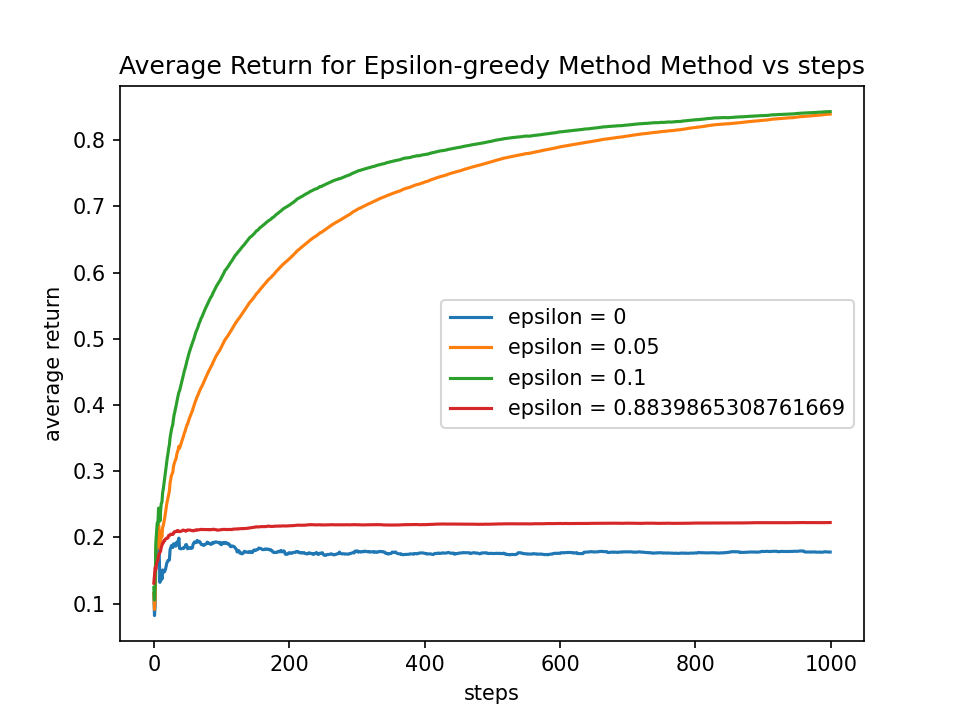

<IPython.core.display.Javascript object>


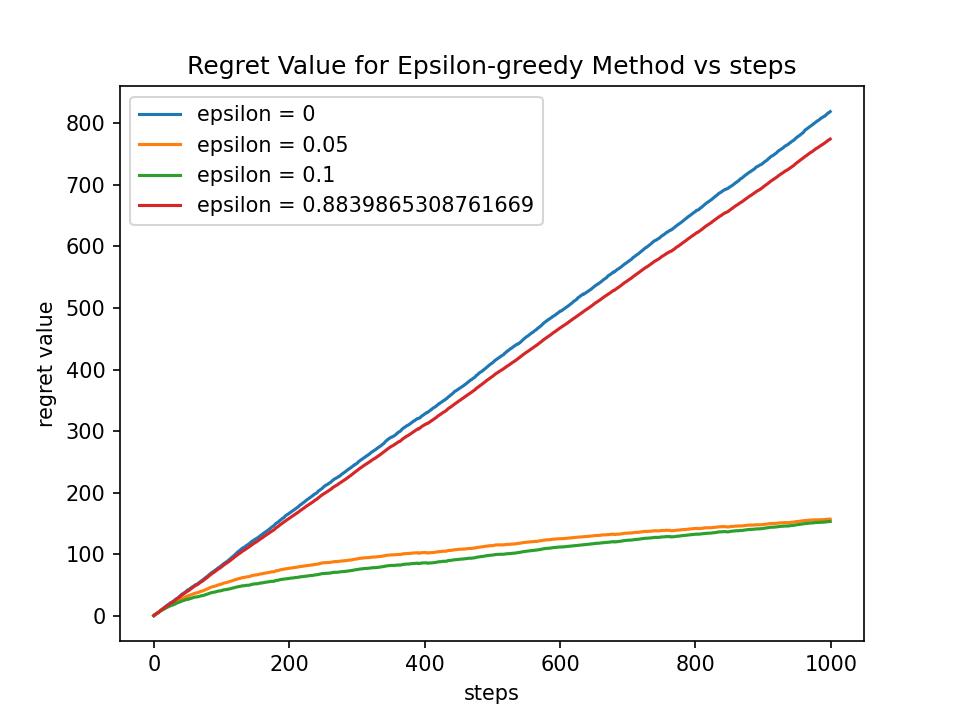

<IPython.core.display.Javascript object>


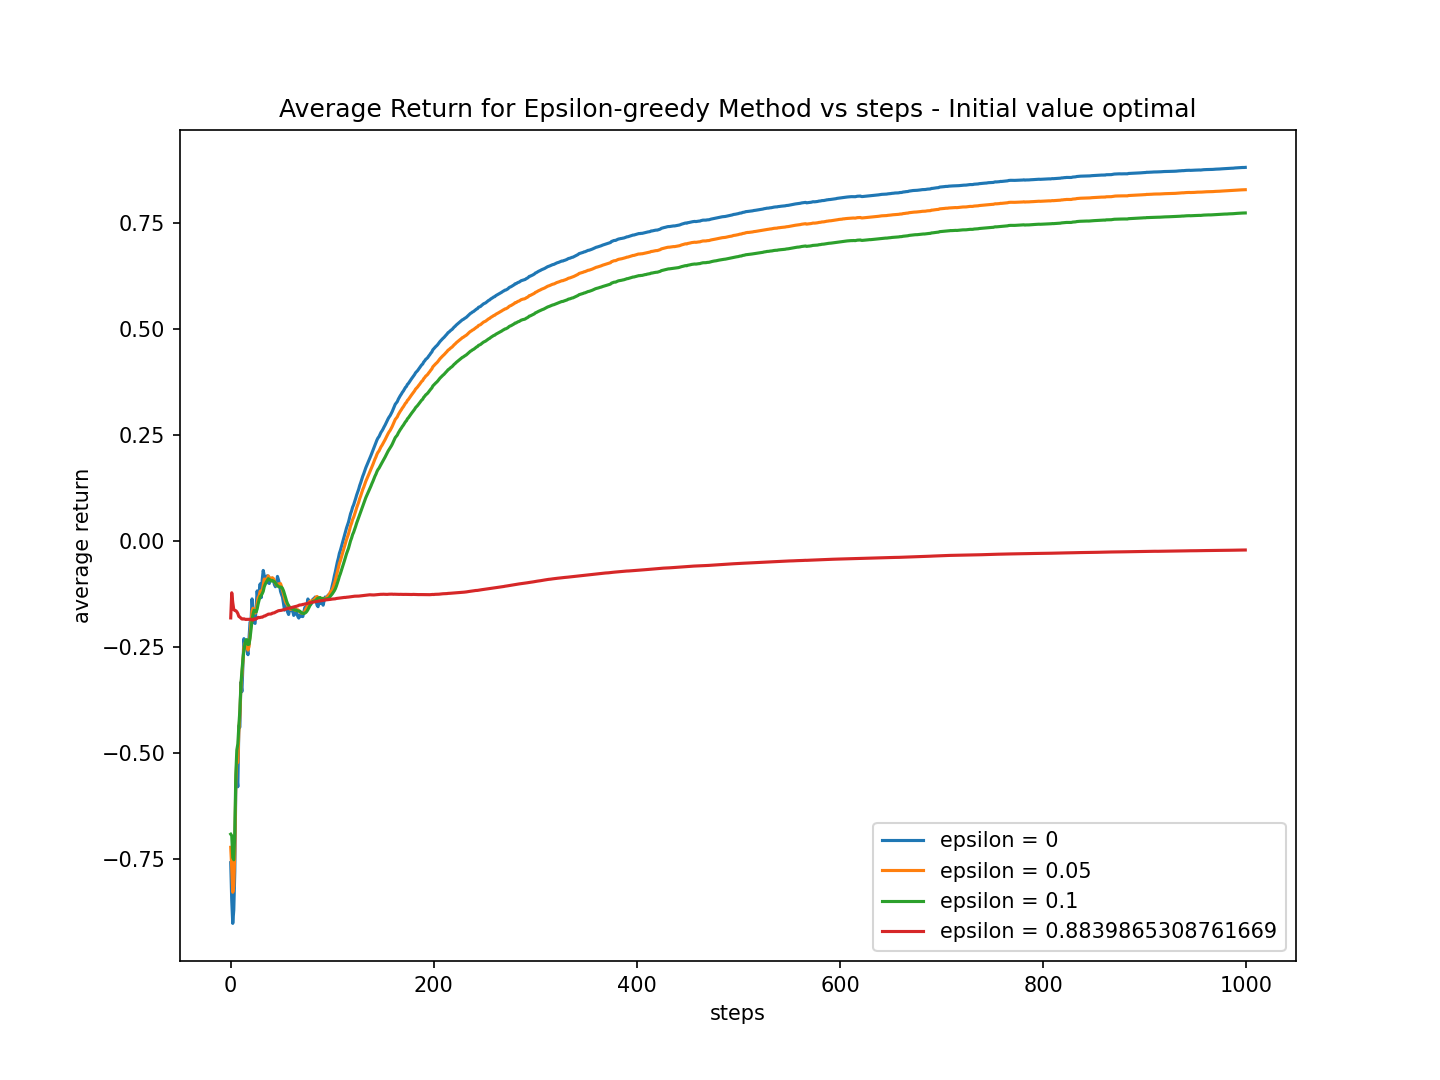

<IPython.core.display.Javascript object>


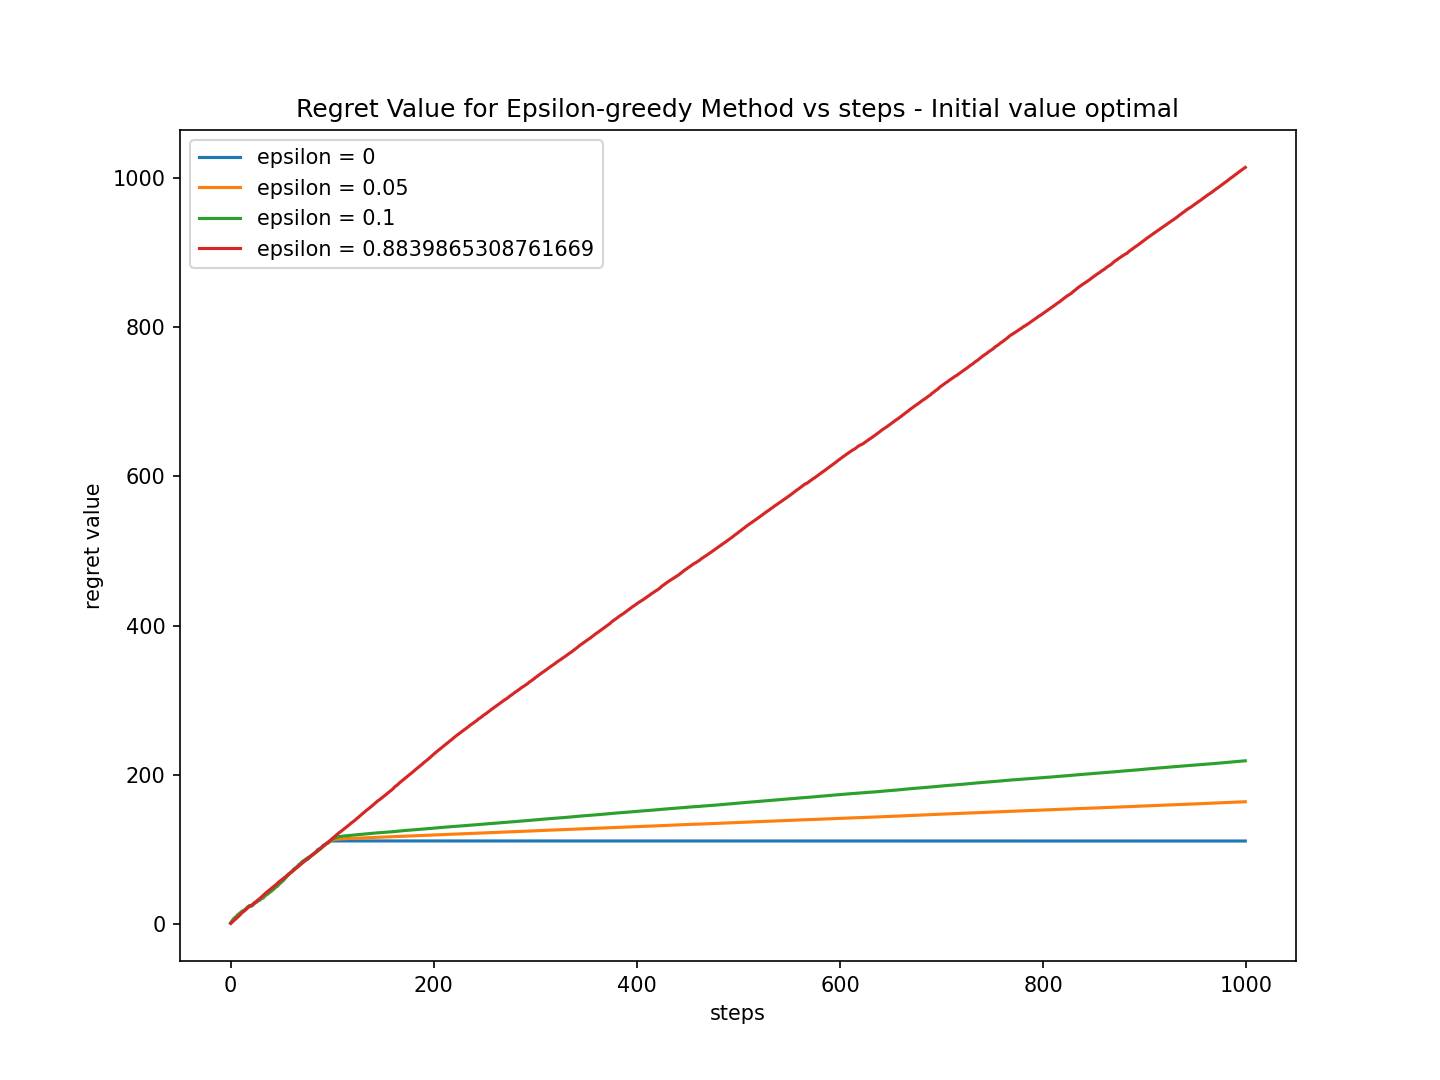

In [88]:
visualization(1000, 100, False)
visualization(1000, 100, True)

It seems like with optimal initial value, the algorithm performs better with $\epsilon = 0$. So In the later application, I decide to use optimal initial value for stock trading.

## Upper Confidence Bound Algorithm
Here I also implement the Upper Confidence Bound method for this question. The UCB1 method do not require the mean of stock return to be stationary. Note according to UCB, the value function is 
$$\begin{align}
V_{t} = Q_{t}(a) + c*\sqrt{\frac{ln(t)}{N_{t}(a)}}
\end{align}
$$
where t is the number of rounds, c is the degree of exploration, $Q_{t}(a)$ is the estimated average return for stock a, $N_{t}(a)$ is the number we pick the stock and $V_{t}$ is the value of stock a at time t.

In [89]:
class ucb_agent():
    def __init__(self, n, c):
        self.stock_number = n
        self.degree_of_exploration = c
        self.stock_estimated_value = [0]*n
        self.stock_estimated_return = [0]*n
        self.stock_chosen_number = [0]*n
        self.regret_value = 0
        self.average_return = 0
        self.regret_value_history = []
        self.average_return_history = []
        self.cummulative_return = []
    
    def pick_stock(self):
        chosen_stock = self.stock_estimated_value.index(max(self.stock_estimated_value))
        return chosen_stock
    
    def update(self, stock_values, chosen_stock, optimal_stock, t):
        self.stock_chosen_number[chosen_stock] += 1
        self.stock_estimated_return[chosen_stock] += (stock_values[chosen_stock] - self.stock_estimated_return[chosen_stock])\
        /self.stock_chosen_number[chosen_stock]
        for i in range(self.stock_number):
            if self.stock_chosen_number[i] > 0:
                self.stock_estimated_value[i] = self.stock_estimated_return[i] + self.degree_of_exploration*math.sqrt(np.log(t)\
                                                                                    /self.stock_chosen_number[i])
            else:
                self.stock_estimated_value[i] = 100
        self.average_return += (stock_values[chosen_stock] - self.average_return)/t
        self.regret_value += stock_values[optimal_stock] - stock_values[chosen_stock]
        self.average_return_history.append(self.average_return)
        self.regret_value_history.append(self.regret_value)
        self.cummulative_return.append(self.average_return*t)

In [90]:
def ucb(m, c, n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock):
    investor_2 = ucb_agent(n, c)
    for i in range(m):
        chosen_stock = investor_2.pick_stock()
        stock_values = stock_returns[:, i]
        investor_2.update(stock_values, chosen_stock, optimal_stock, i + 1)
    return investor_2.average_return_history, investor_2.regret_value_history, investor_2.cummulative_return

In [102]:
def visualization_1(m, n, test = 300):
    steps = list(range(m))
    average_returns = []
    regret_values = []
    standard_deviation = 1
    degree_of_exploration = [0, 1, 1.5, 2]
    stock_returns, stock_mean_returns = stock_return_generate(m, n, standard_deviation)
    optimal_stock = get_optimal_price(stock_mean_returns)
    for j in range(len(degree_of_exploration)):
        average_return_ = []
        regret_value_ = []
        for k in range(test):
            _average_return_, _regret_value_ = ucb(m, degree_of_exploration[j], n, standard_deviation,\
                                                      stock_returns, stock_mean_returns, optimal_stock)[:2]
            average_return_.append(_average_return_)
            regret_value_.append(_regret_value_)
        average_return_ = np.array(average_return_)
        regret_value_ = np.array(regret_value_)
        average_return_ = np.mean(average_return_, axis = 0)
        regret_value_ = np.mean(regret_value_, axis = 0)
        average_returns.append(average_return_)
        regret_values.append(regret_value_)
    algorithm = 'UCB'
    plot_graph(degree_of_exploration, steps, average_returns, regret_values, algorithm)

Note if the algorithm runs slow, you can change the test number in the function params. 

<IPython.core.display.Javascript object>


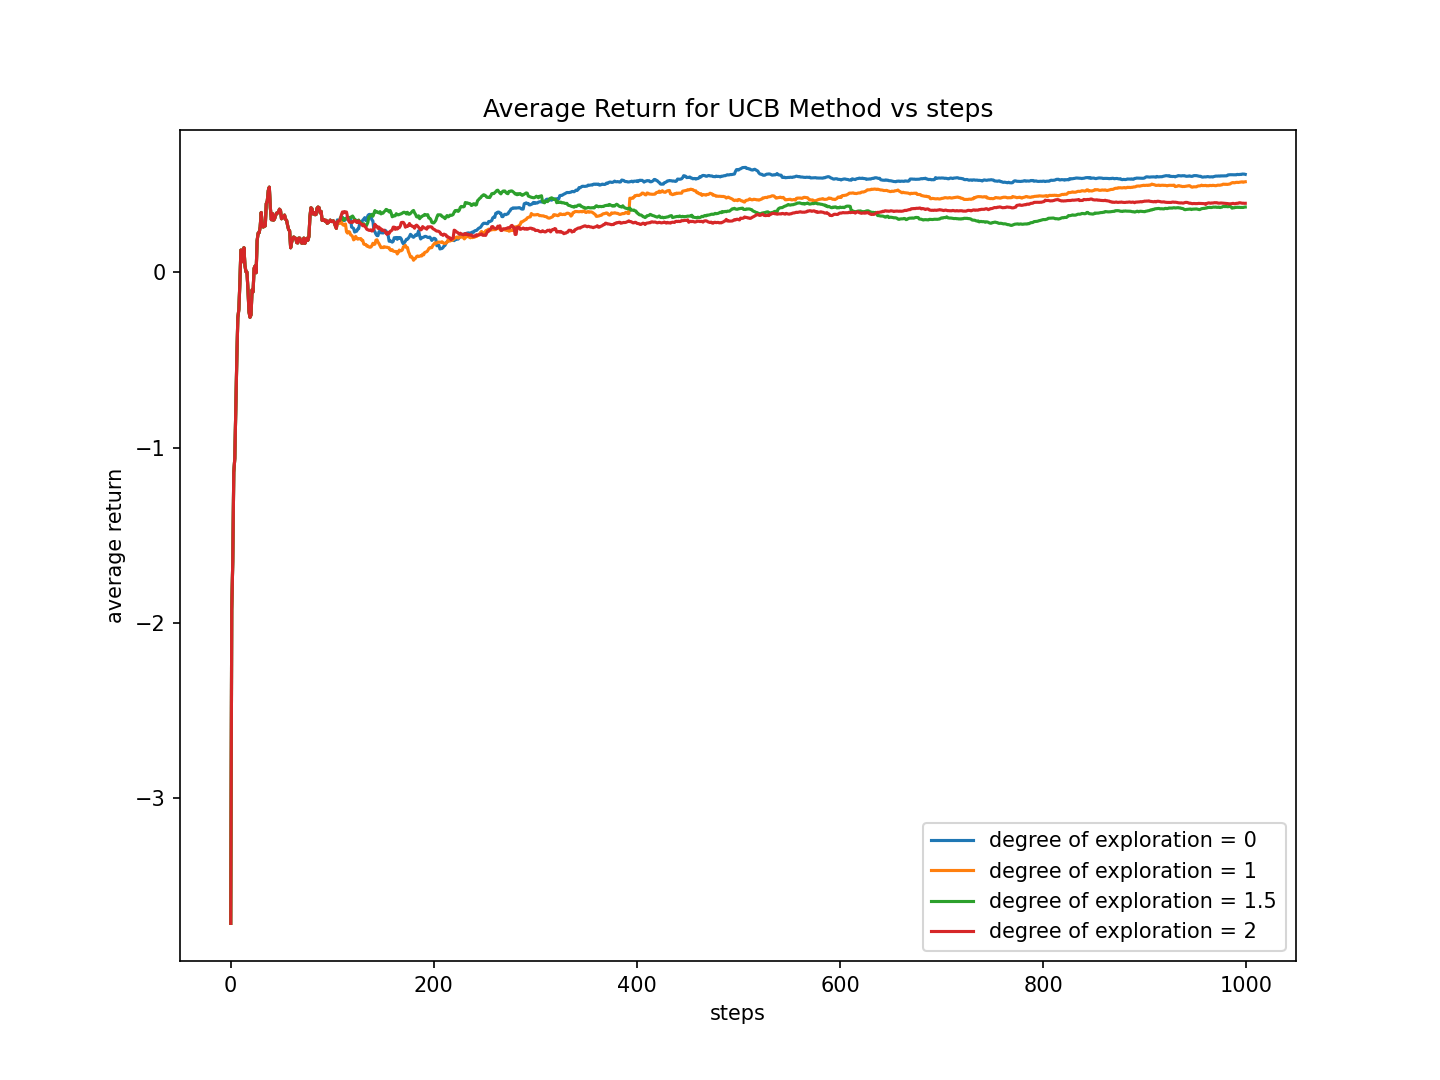

<IPython.core.display.Javascript object>


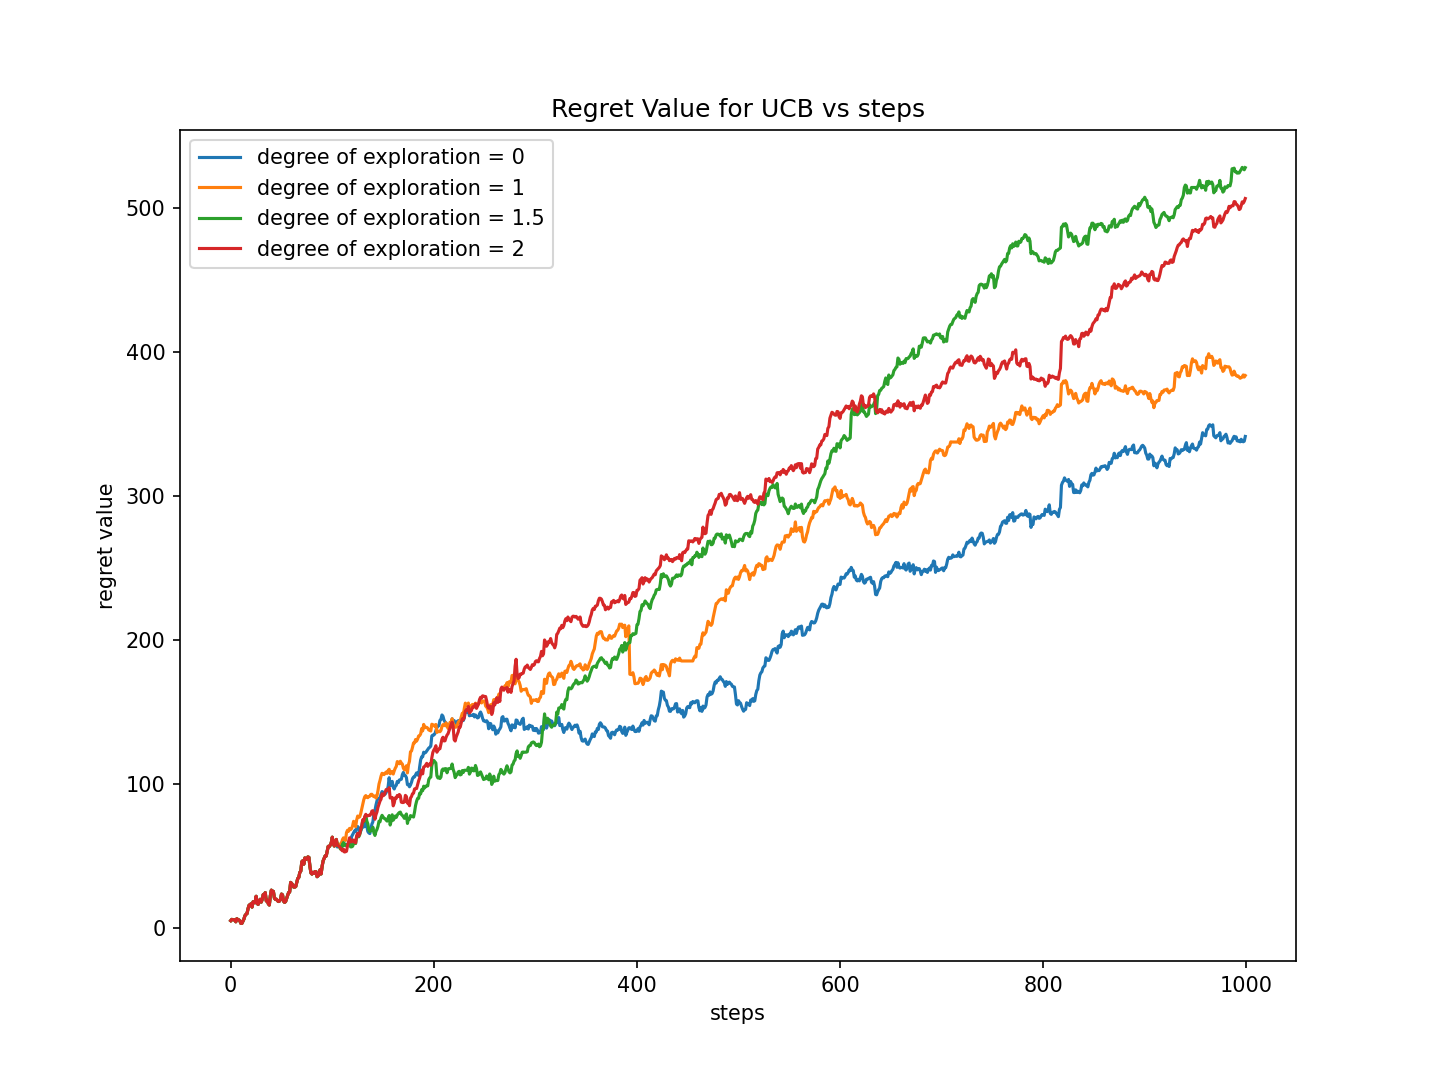

In [103]:
visualization_1(1000, 100)

## Gradient Bandit Algorithm
Next I implement the gradient bandit algorithm for this problem. We let the probability of picking up a stock a to be 
$$
\begin{align}
P[A_{t} = a] = \frac{e^{H_{t}(a)}}{\sum_{b=1}^{n}e^{H_{t}(b)}} = \pi_{t}(a)
\end{align}
$$
where preference value $H_{t}(a) = 0$ when $t = 0$ and
$$
H_{t+1}(a) = H_{t}(a) + \alpha(R_{t} - \bar{R_{t}})(1-\pi_{t}(a)) \\
H_{t+1}(b) = H_{t}(b) + \alpha(R_{t} - \bar{R_{t}})\pi_{t}(b)
$$
where b not equal to a, $\bar{R_{t}}$ is the average return till time t.

In [104]:
class gradient_agent():
    def __init__(self, n, a):
        self.stock_number = n
        self.degree_of_exploration = a
        self.stock_preference_value = [0]*n
        self.stock_probability = [1/n]*n
        self.regret_value = 0
        self.average_return = 0
        self.regret_value_history = []
        self.average_return_history = []
        self.cummulative_return = []
    
    def pick_stock(self):
        chosen_stock = np.random.choice(list(range(self.stock_number)), p = self.stock_probability)
        return chosen_stock
    
    def update(self, stock_values, chosen_stock, optimal_stock, t):
        for i in range(self.stock_number):
            if i == chosen_stock:
                self.stock_preference_value[i] += self.degree_of_exploration*(1\
                                                -self.stock_probability[i])*(stock_values[chosen_stock] - self.average_return)
            else:
                self.stock_preference_value[i] += self.degree_of_exploration*\
                self.stock_probability[i]*(stock_values[chosen_stock] - self.average_return)
        for i in range(self.stock_number):
            self.stock_probability[i] = math.exp(self.stock_preference_value[i])/np.sum(np.exp(self.stock_preference_value))
        self.average_return += (stock_values[chosen_stock] - self.average_return)/t
        self.regret_value += stock_values[optimal_stock] - stock_values[chosen_stock]
        self.average_return_history.append(self.average_return)
        self.regret_value_history.append(self.regret_value)
        self.cummulative_return.append(self.average_return*t)

In [105]:
def gradient(m, a, n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock):
    investor_3 = gradient_agent(n, a)
    for i in range(m):
        chosen_stock = investor_3.pick_stock()
        stock_values = stock_returns[:, i]
        investor_3.update(stock_values, chosen_stock, optimal_stock, i + 1)
    return investor_3.average_return_history, investor_3.regret_value_history, investor_3.cummulative_return

In [116]:
def visualization_2(m, n, test = 300):
    steps = list(range(m))
    average_returns = []
    regret_values = []
    standard_deviation = 1
    degree_of_exploration = [0.1, 0.5, 1, 1.5, 2]
    stock_returns, stock_mean_returns = stock_return_generate(m, n, standard_deviation)
    optimal_stock = get_optimal_price(stock_mean_returns)
    for j in range(len(degree_of_exploration)):
        average_return_ = []
        regret_value_ = []
        for k in range(test):
            _average_return_, _regret_value_ = gradient(m, degree_of_exploration[j], n,\
                                                standard_deviation, stock_returns, stock_mean_returns, optimal_stock)[:2]
            average_return_.append(_average_return_)
            regret_value_.append(_regret_value_)
        average_return_ = np.array(average_return_)
        regret_value_ = np.array(regret_value_)
        average_return_ = np.mean(average_return_, axis = 0)
        regret_value_ = np.mean(regret_value_, axis = 0)
        average_returns.append(average_return_)
        regret_values.append(regret_value_)
        
    algorithm = 'Gradient Bandit Method'
    plot_graph(degree_of_exploration, steps, average_returns, regret_values, algorithm)
    

Note if the algorithm runs slow, you can change the test number in the function params

<IPython.core.display.Javascript object>


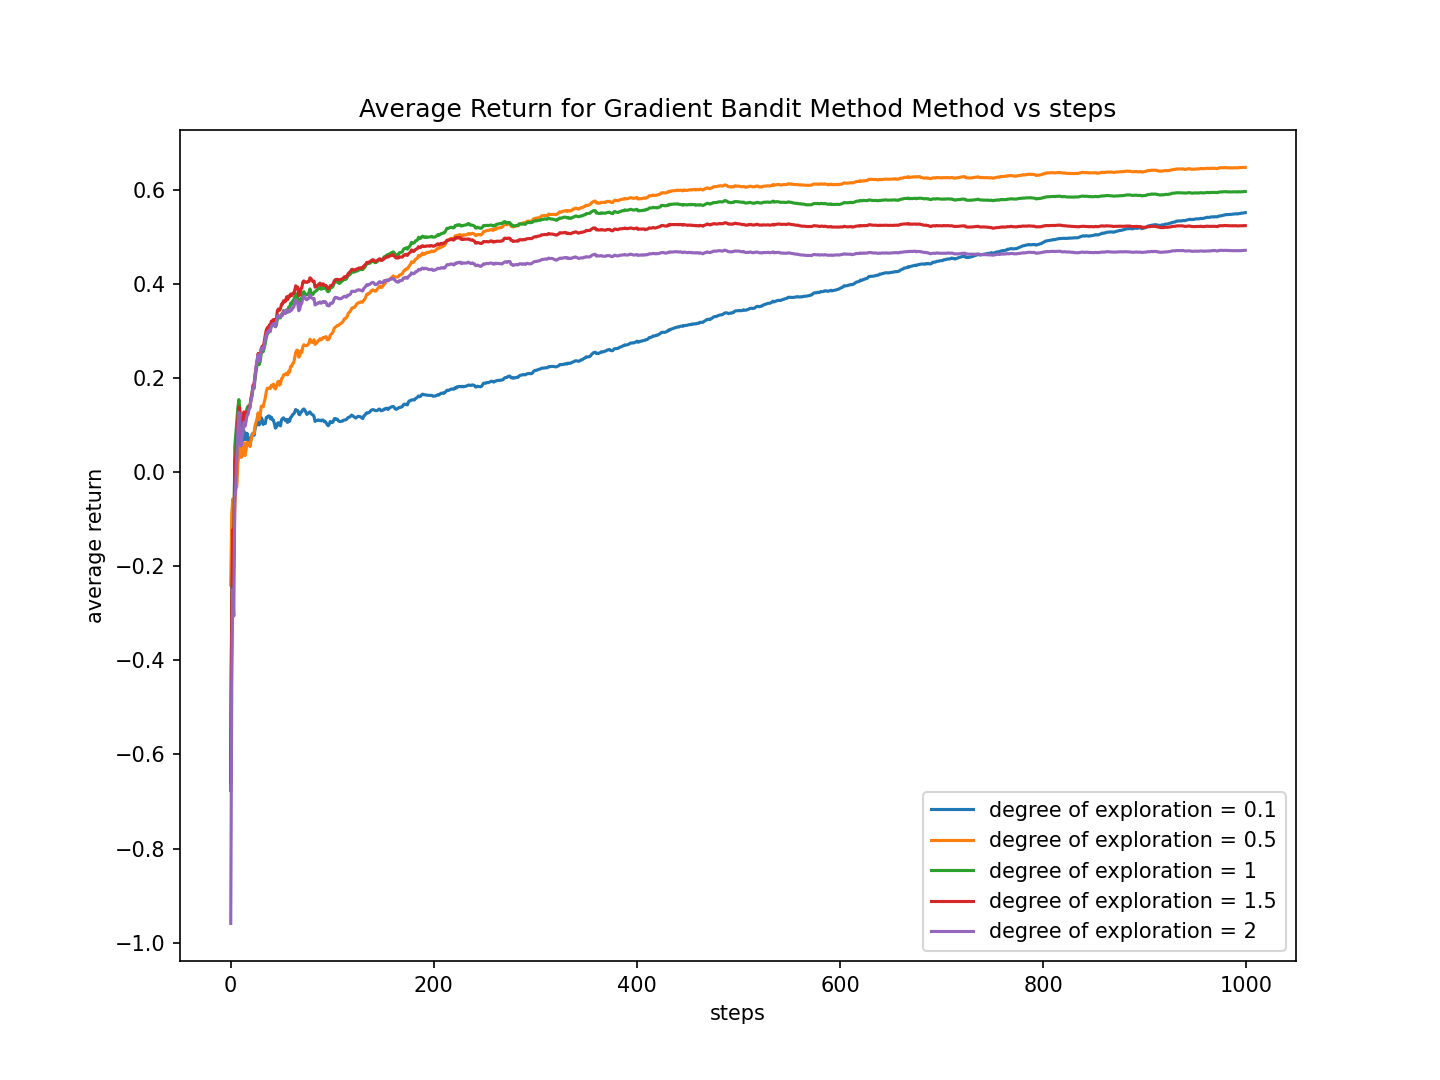

<IPython.core.display.Javascript object>


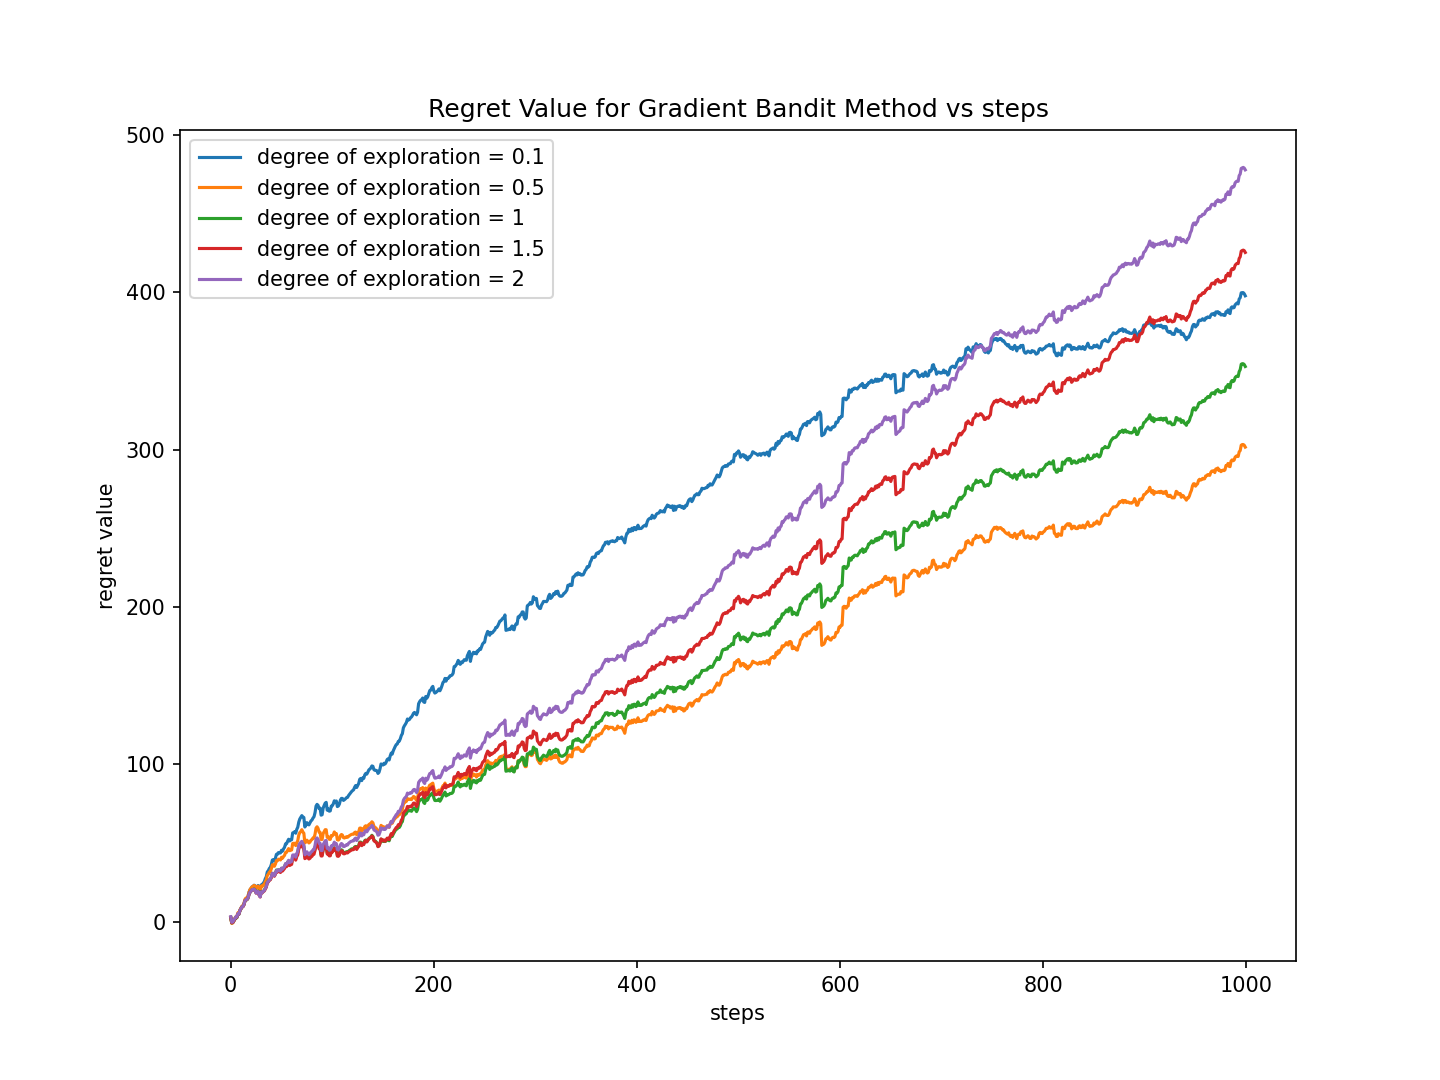

In [118]:
visualization_2(1000, 50)

## Contextual Bandit Algorithm
Next I want to demonstrate the contextual bandit algorithm for this problem. For simplicity, I want to use linear UCB algorithm and Fama-French 3 model. Note the daily return of one stock follows:
$$\begin{align}
R_{t} = \beta_{1}(Mrt_{t}-rf_{t})+\beta_{2}SMB_{t}+\beta_{3}HML_{t}+rf_{t}+\beta_{4}MOM12_{t}
\end{align}
$$
Let $\theta(a) = [\beta_{1}(a), \beta_{2}(a), \beta_{3}(a), \beta_{4}(a)]$ for action a.
I want to find the regularized least square estimator $\theta^{*}$
$$
\begin{align}
loss = \sum_{i=1}^{m}(c_{a,i}-\sum_{j=1}^{d}\theta_{a,j}x_{ij})^{2} + \lambda\sum_{j=1}^{d}\theta_{a,j}^{}
\end{align}
$$
where $c_{a,i}$ is the reward for stock $a$ at time $i$, $x_{ij}$ is the $j$-th element for the context at time i for stock a. And we get the solution by choosing $\lambda = 1$
$$
\begin{align}
\theta_{a} = (D_{a}^{T}D_{a} + I)^{-1}D_{a}^{T}c_{a}
\end{align}
$$
where $D_{a} = [x_{i1}, x_{i2}, ..., x_{id}]^{T}$. If we use ridge regression, we can get 
$$
\begin{align}
\theta_{a}\sim N((D_{a}^{T}D_{a} + I)^{-1}D_{a}^{T}c_{a}, (D_{a}^{T}D_{a} + I)^{-1})
\end{align}
$$
and 
$$
\begin{align}
r_{t,a}\sim N(x_{t,a}^{T}\hat{\theta_{a}}, x_{t,a}^{T}A_{a}^{-1}x_{t,a})
\end{align}
$$
where $A_{a}=D_{a}^{T}D_{a} + I$. Hence we can choose the degree of exploration $\alpha$ and get the upper confidence bound 
$$
\begin{align}
V_{t,a} = x_{t,a}^{T}\hat{\theta_{a}} + \alpha \sqrt{x_{t,a}^{T}A_{a}^{-1}x_{t,a}}
\end{align}
$$
and pick the stock with largest $V_{t,a}$ value.

In [158]:
class linUCB_agent():
    def __init__(self, n, c, d=4):
        self.stock_number = n
        self.degree_of_exploration = c
        self.d = d
        self.stock_estimated_value = [0]*n
        self.regret_value = 0
        self.average_return = 0
        self.regret_value_history = []
        self.average_return_history = []
        self.cummulative_return = []
        self.A = [[]]*n
        self.b = [[]]*n
        
    def pick_stock(self, environment, MOM12):
        for i in range(self.stock_number):
            if len(self.A[i]) == 0:
                self.A[i] = np.eye(self.d)
                self.b[i] = np.zeros(self.d)
            theta = inv(self.A[i]) @ self.b[i]
            temp_x = np.array(np.append(environment, MOM12[i]))
            self.stock_estimated_value[i] = temp_x.T @ theta + self.degree_of_exploration\
            * np.sqrt(temp_x.T @ inv(self.A[i]) @ temp_x)
        chosen_stock = self.stock_estimated_value.index(max(self.stock_estimated_value))
        return chosen_stock
    
    def update(self, stock_values, chosen_stock, optimal_stock, t, environment, MOM12):
        chosen_x = np.array(np.append(environment, MOM12[chosen_stock]))
        self.A[chosen_stock] += chosen_x @ chosen_x.T
        self.b[chosen_stock] += stock_values[chosen_stock] * chosen_x
        self.average_return += (stock_values[chosen_stock] - self.average_return)/t
        self.regret_value += stock_values[optimal_stock] - stock_values[chosen_stock]
        self.average_return_history.append(self.average_return)
        self.regret_value_history.append(self.regret_value)
        self.cummulative_return.append(self.average_return*t)

In [159]:
def linUCB(m, c, n, stock_returns, stock_mean_returns, optimal_stock, environment, MOM12):
    investor_4 = linUCB_agent(n, c)
    for i in range(m):
        chosen_stock = investor_4.pick_stock(environment[:, i], MOM12[:, i])
        stock_values = stock_returns[:, i]
        investor_4.update(stock_values, chosen_stock, optimal_stock, i + 1, environment[:, i], MOM12[:, i])
    return investor_4.average_return_history, investor_4.regret_value_history, investor_4.cummulative_return

## Real Stock Trading Performance
Note we want to apply all the methods above for real stock data analysis. I use stock price for the top 3 market cap companies in each industry in USA from Yahoo Finance from 2016-02-05 to 2022-03-05. I use daily log return for analysis. As for model, I use $\epsilon=0.1$ for $\epsilon$-greedy algorithm, $1$ for degree of exploration for UCB, $0.5$ for degree of exploration for linear UCB. As for the linear UCB, I use the model mentioned above and the data for the factors for Fama French are from Kenneth R. French - Data Library. For the MOM12 factor, I use the previous 255-day return.

In [160]:
def calculate_average(average_return, regret_value, cummulative_return):
    average_return = np.array(average_return)
    regret_value = np.array(regret_value)
    cummulative_return = np.array(cummulative_return)
    average_return = np.mean(average_return, axis = 0)
    regret_value = np.mean(regret_value, axis = 0)
    cummulative_return = np.mean(cummulative_return, axis = 0)
    return average_return, regret_value, cummulative_return

In [176]:
def real_stock_data_training(test = 200):
    d = 4
    data = pd.read_csv('data_1.csv', index_col = 'Date')
    stock_return = data.iloc[:, :41]
    stock_mean_returns = list(stock_return.mean(axis = 0))
    stock_returns = stock_return.to_numpy().T
    n = len(stock_return.columns)
    m = len(stock_return.index)
    steps = list(range(m))
    optimal_stock = stock_mean_returns.index(max(stock_mean_returns))
    MOM12 = data.iloc[:, 41:-d + 1]
    MOM12 = MOM12.to_numpy().T
    environment = data.iloc[:, -d + 1:]
    environment = environment.to_numpy().T
    epsilon = 0.1
    standard_deviation = 1
    average_return_1, regret_value_1, cummulative_return_1 = [], [], []
    
    # Note for epsilon-greedy and gradient descent, we need to calcultate
    # the average return since its value is not deterministic
    for i in range(test):
        average_return_, regret_value_, cummulative_return_ = epsilon_greedy(m, epsilon,\
                                                    n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock)
        average_return_1.append(average_return_)
        regret_value_1.append(regret_value_)
        cummulative_return_1.append(cummulative_return_)
    average_return_1, regret_value_1, cummulative_return_1 = calculate_average(average_return_1,\
                                                                               regret_value_1, cummulative_return_1)
    average_return_2, regret_value_2, cummulative_return_2 = ucb(m, 1, n, standard_deviation,\
                                                                 stock_returns, stock_mean_returns, optimal_stock)
    average_return_3, regret_value_3, cummulative_return_3 = [], [], []
    for i in range(test):
        average_return_, regret_value_, cummulative_return_ = epsilon_greedy(m, epsilon,\
                                n, standard_deviation, stock_returns, stock_mean_returns, optimal_stock, constant_step = 20)
        average_return_3.append(average_return_)
        regret_value_3.append(regret_value_)
        cummulative_return_3.append(cummulative_return_)
    average_return_3, regret_value_3, cummulative_return_3 = calculate_average(average_return_3,\
                                                                               regret_value_3, cummulative_return_3)
    average_return_4, regret_value_4, cummulative_return_4 = [], [], []
    for i in range(test):
        average_return_, regret_value_, cummulative_return_ = gradient(m, 1, n, standard_deviation, stock_returns,\
                                                                       stock_mean_returns, optimal_stock)
        average_return_4.append(average_return_)
        regret_value_4.append(regret_value_)
        cummulative_return_4.append(cummulative_return_)
    average_return_4, regret_value_4, cummulative_return_4 = calculate_average(average_return_4,\
                                                                               regret_value_4, cummulative_return_4)

    
    average_return_5, regret_value_5, cummulative_return_5 = linUCB(m, 0.5, n, stock_returns,\
                                                                    stock_mean_returns, optimal_stock, environment, MOM12)
    
    
    
    average_return = pd.DataFrame({'epsilon-greedy-stationary': average_return_1, 'UCB1': average_return_2,\
                                   'epsilon greedy nonstationary': average_return_3, 'gradient bandit': average_return_4,\
                                   'linear UCB': average_return_5}, index = steps)
    
    average_return.plot(title = 'Average Return vs Steps')
    plt.show()
    
    regret_value = pd.DataFrame({'epsilon-greedy-stationary': regret_value_1, 'UCB1': regret_value_2,\
                                   'epsilon greedy nonstationary': regret_value_3, 'gradient bandit': regret_value_4,\
                                   'linear UCB': regret_value_5}, index = steps)
    regret_value.plot(title = 'Regret Value vs Steps')
    plt.show()
    
    cummulative_portfolio_value = pd.DataFrame({'epsilon-greedy-stationary': cummulative_return_1, 'UCB1': cummulative_return_2,\
                                   'epsilon greedy nonstationary': cummulative_return_3,\
                                       'gradient bandit': cummulative_return_4,\
                                   'linear UCB': cummulative_return_5}, index = data.index)
    cummulative_portfolio_value['market portfolio'] = stock_return.mean(axis = 1).cumsum()
    cummulative_portfolio_value.plot(title = 'Cummulative Portfolio Log Value vs Date')
    plt.show()


    average_return['market portfolio'] = stock_return.mean(axis = 1).cumsum().to_list()
    average_return['market portfolio'].iloc[-1] = average_return['market portfolio'].iloc[-1]/m
    
    annualized_return = np.round((np.exp(np.array(average_return.iloc[-1,:])*252) - 1)*100, 2)
    methods = cummulative_portfolio_value.columns
    
    daily_return = (cummulative_portfolio_value.diff().dropna()).apply(np.exp) - 1
    sharpe = daily_return.mean(axis = 0)/daily_return.std(axis = 0)*np.sqrt(252)
    beta = []
    alpha = []
    for i in range(len(methods) - 1):
        X = sm.add_constant(np.array(daily_return.iloc[:,i]))
        params = sm.OLS(np.array(daily_return['market portfolio']), X).fit().params
        beta.append(params[1])
        alpha.append(params[0])
    beta.append(1)
    alpha.append(0)
    annualized_return_df = pd.DataFrame({'annualized return %': annualized_return, \
                                         'sharpe ratio': sharpe, 'beta': beta, 'alpha': alpha}, index = methods)
    print(annualized_return_df)

<IPython.core.display.Javascript object>


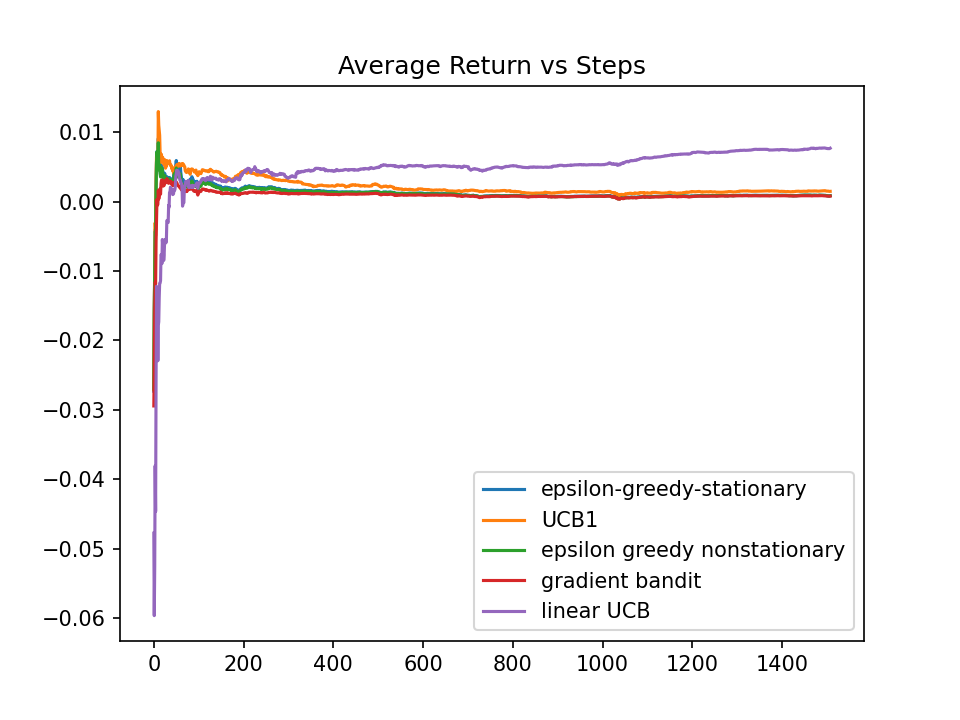

<IPython.core.display.Javascript object>


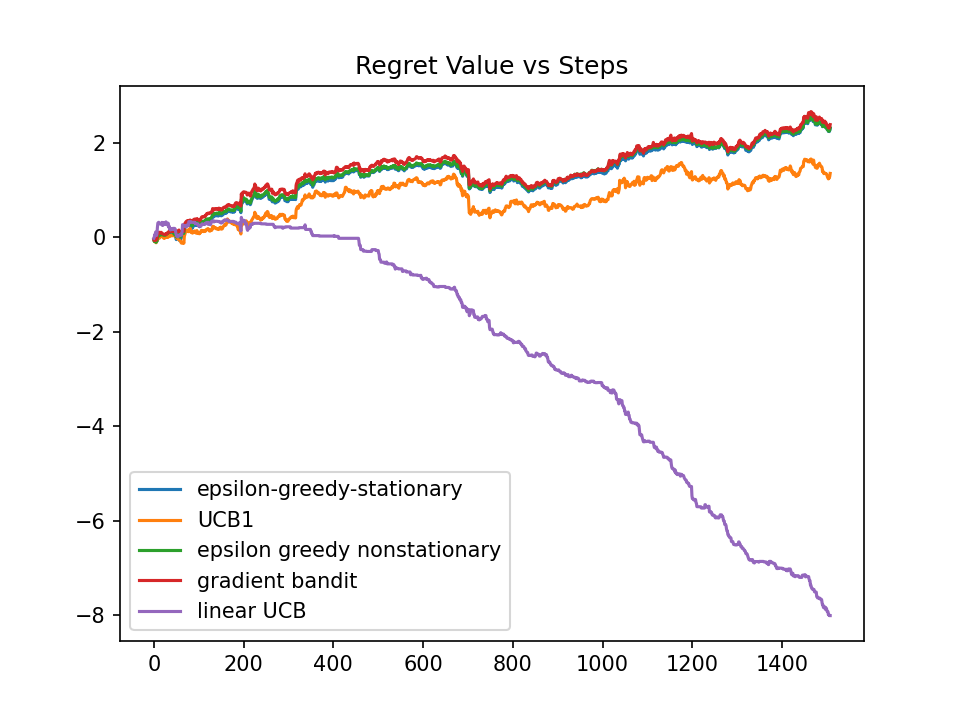

<IPython.core.display.Javascript object>


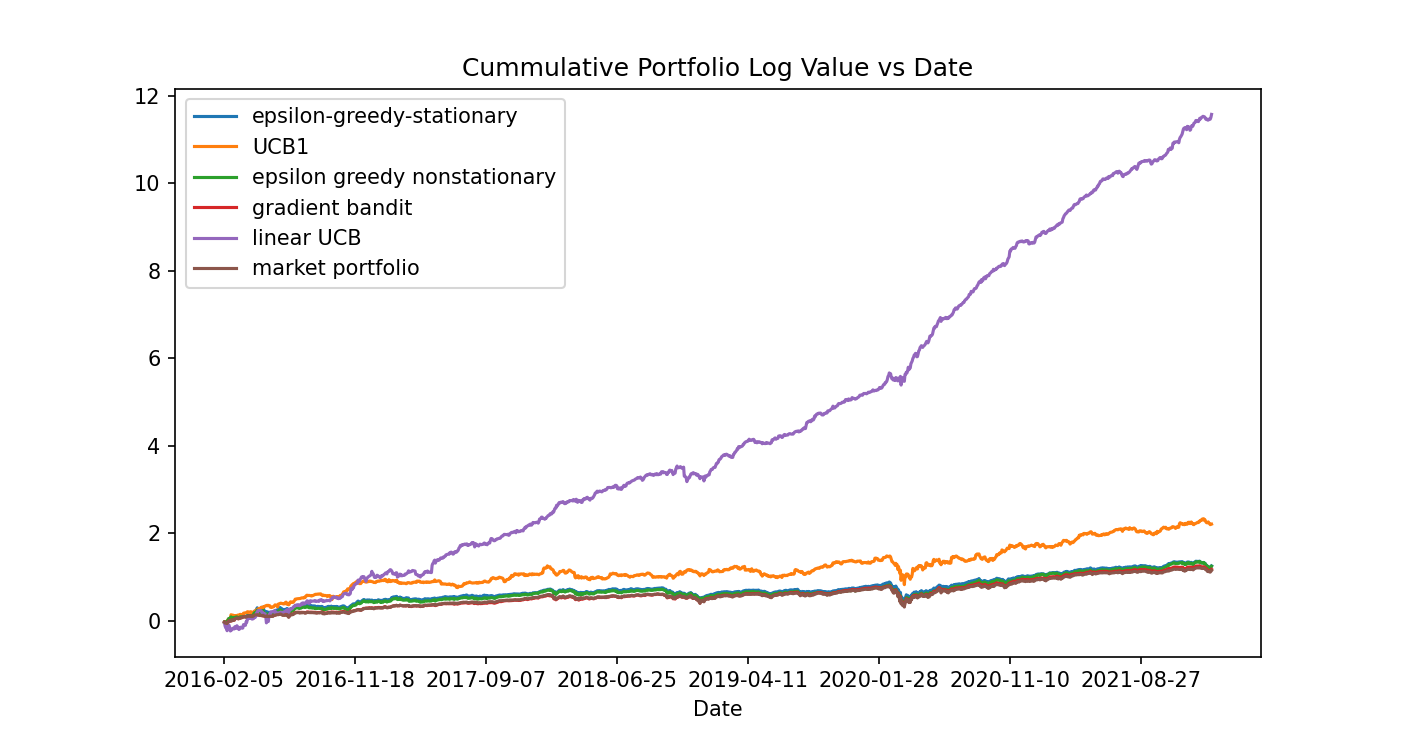

                              annualized return %  sharpe ratio      beta  \
epsilon-greedy-stationary                   23.40      1.070066  0.822129   
UCB1                                        44.76      1.243389  0.347013   
epsilon greedy nonstationary                23.24      1.080632  0.842605   
gradient bandit                             21.79      1.118960  0.991239   
linear UCB                                 592.44      4.757560  0.256179   
market portfolio                            21.26      1.099329  1.000000   

                                 alpha  
epsilon-greedy-stationary     0.000078  
UCB1                          0.000262  
epsilon greedy nonstationary  0.000066  
gradient bandit              -0.000011  
linear UCB                   -0.001215  
market portfolio              0.000000  


In [177]:
real_stock_data_training()

## Conclusion
It seemes like the linear UCB and UCB1 algorithms captures some signals outside of the market portfolio compared to other algorithms, especially for linear UCB. Since linear UCB uses factor model for choosing stocks, which means it use extra information compared to other algorithms, it is understandable that it outperforms than others. Also note that UCB1 itself outperforms than other algorithms. Hence I conclude that UCB and linear UCB might be a better algorithm for trading stock.